In [3]:
import os
if not os.getcwd().endswith('CIoTS'):
    os.chdir('../..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from CIoTS import *

# Execution

In [1]:
from itertools import product

dimensions = [3]
incoming_edges = [3]
taus = [5, 10]
autocorr = [0.75]
data_length = [1000]
runs = range(5)

setups = list(product(dimensions, incoming_edges, taus, autocorr, data_length, runs))

## Data generation

In [4]:
import pickle
data_path = 'notebooks/ICML/icml_data/'

for dim, in_edges, tau, autocorr, data_length, run in setups:
    generator = CausalTSGenerator(dimensions=dim, max_p=tau, data_length=data_length,
                                  incoming_edges=in_edges, autocorrelation=autocorr)
    ts = generator.generate()
    pickle.dump(generator, open(data_path + f't={tau}_d={dim}_in={in_edges}_{run}.pickle', 'wb'))

## 1. Compute $F_1$ for known $\tau$

PC1 iterative vs. PC1 non-iterative

Also check for $\tau - k$ and $\tau + k$ to visualize importance of $\tau$ estimation

In [5]:
import pickle

data_path = 'notebooks/ICML/icml_data/'
results_path = 'notebooks/ICML/icml_results/'
results = pd.DataFrame()
k = 2

algorithms = [pc_incremental, pc_incremental_pc1]

for dim, in_edges, tau, _, _, run in setups:
    generator = pickle.load(open(data_path + f't={tau}_d={dim}_in={in_edges}_{run}.pickle', 'rb'))
    
    df_dict = {'dimension': dim, 'max time lag': tau, 'incoming edges': in_edges, 'run': run}
    for algorithm in algorithms:
        _, graphs, _, _, _ = algorithm(partial_corr_test, generator.ts, max_p=tau+k, 
                               use_stopper=False, alpha=0.05, verbose=True)
        for offset in range(-k, k+1):
            f1_score = evaluate_edges(generator.graph, graphs[tau+offset])['f1-score']
            df_dict[algorithm.__name__ + '_f1' + (f'+{offset}' if offset>=0 else str(offset))] = f1_score

    results = results.append(df_dict, ignore_index=True)

results.to_csv(results_path + f'experiment1.csv')

/usr/local/lib/python3.7/site-packages/scipy/linalg/basic.py:1321: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  x, resids, rank, s = lstsq(a, b, cond=cond, check_finite=False)


## 2. Compute estimate $\hat{\tau}$ for unknown $\tau$

Test VAR estimation vs. Incremental BIC (for $PC_1$) vs. cross-correlation-based

In [ ]:
import pickle

data_path = 'notebooks/ICML/icml_data/'
results_path = 'notebooks/ICML/icml_results/'
results = pd.DataFrame()

for dim, in_edges, tau, _, _, run in setups:
    generator = pickle.load(open(data_path + f't={tau}_d={dim}_in={in_edges}_{run}.pickle', 'rb'))
    
    df_dict = {'dimension': dim, 'max time lag': tau, 'incoming edges': in_edges, 'run': run}
    algorithms = [
        (pc_incremental_pc1, {
            'indep_test': partial_corr_test,
            'ts': generator.ts,
            'max_p': 2*tau,
            'stopper': ICStopper(dim, patiency=2, ic='bic'),
            'verbose': True}, lambda r: r[3].best_tau),
        (var_order_select, {
            'ts': generator.ts, 
            'max_p': 2*tau, 
            'ics': ['bic']}, lambda r: r[0]['bic'][0])
    ]
    for algorithm, params, result_func in algorithms:
        result = algorithm(**params)
        df_dict[algorithm.__name__ + '_tau'] = result_func(result)
    results = results.append(df_dict, ignore_index=True)

results.to_csv(results_path + f'experiment2.csv')

# Visualization

## 1. Visualize $F_1$ for known $\tau$

In [6]:
from functools import reduce
import sys
eps = sys.float_info.epsilon

def plot_f1_groupedbarchart(df_dict, title):
    assert len(df_dict) > 0
    assert reduce(lambda x,y: np.all(x == y), map(lambda e:e.columns, grouped_result.values()))
    bar_labels = [f'$\\tau + {c[1]}$' if c[1]>=0 else f'$\\tau - {abs(c[1])}$'
                  for c in next(iter(grouped_result.values())).columns]
    
    fig, ax = plt.subplots(figsize=(20,10))
    ind = np.arange(len(bar_labels))
    width = 0.7 / len(df_dict)
    
    plots = []
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for w_idx, (algo, f1s) in enumerate(df_dict.items()):
        p = ax.bar(ind + w_idx*width + (width / 2), np.mean(f1s, axis=0), width, 
                   color=color_cycle[w_idx % len(color_cycle)],
                   bottom=0, yerr=np.std(f1s, axis=0))
        plots.append(p[0])

    ax.set_title(title)
    ax.set_xticks(ind + (len(df_dict) * width) / 2)
    ax.set_xticklabels(bar_labels)

    ax.legend(plots, df_dict.keys())
    ax.autoscale_view()

    plt.show()

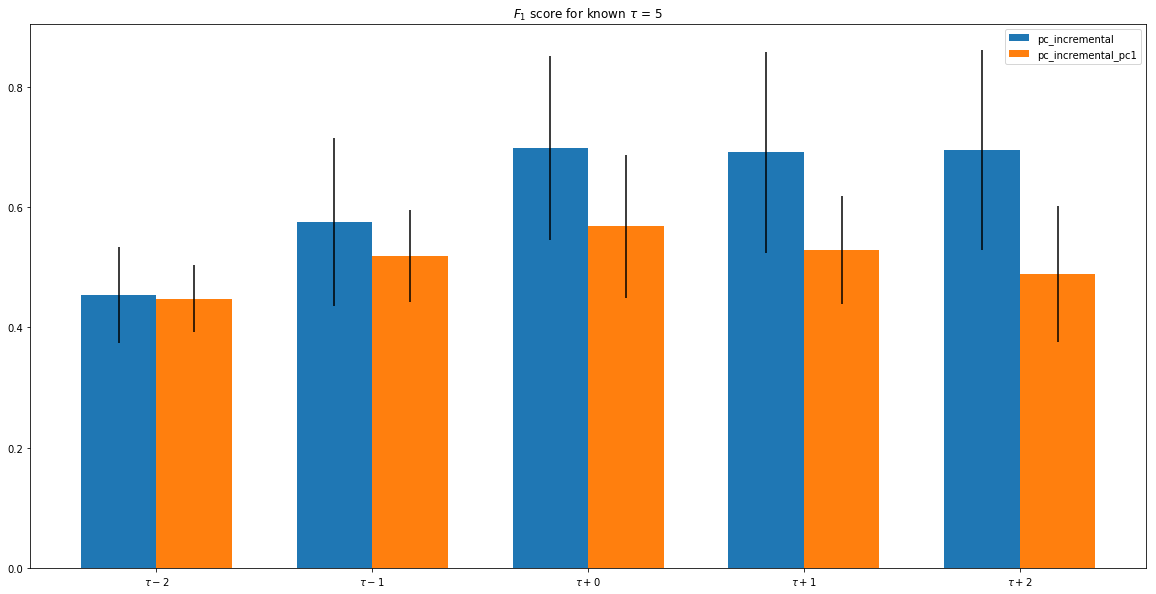

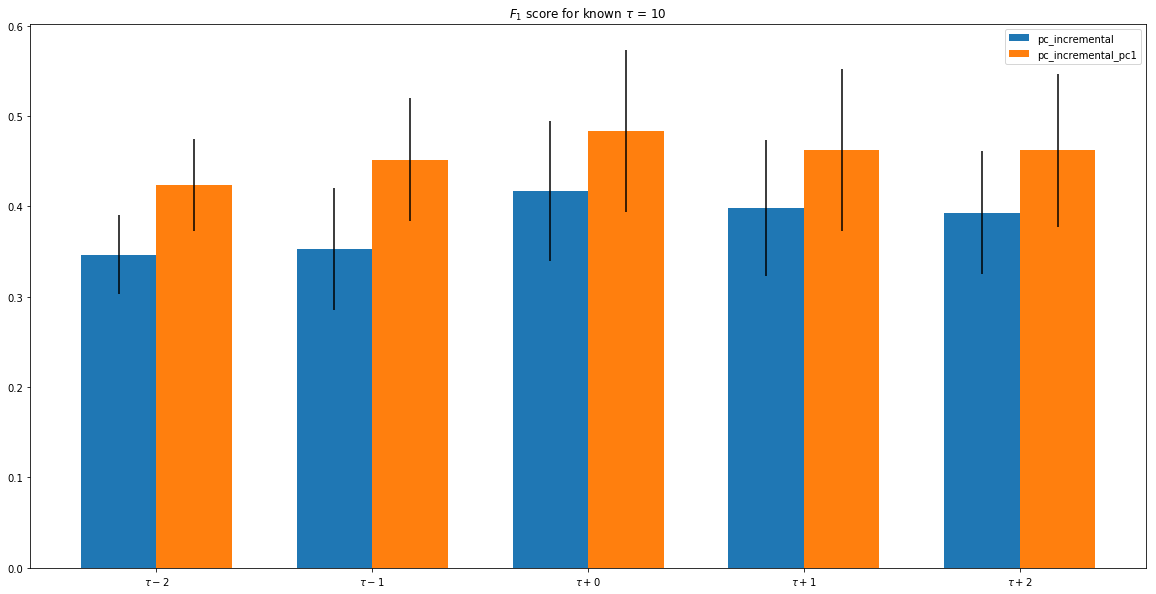

In [7]:
results_path = 'notebooks/ICML/icml_results/'
algorithms = [pc_incremental, pc_incremental_pc1]

results = pd.read_csv(results_path + 'experiment1.csv', index_col=0)
for group, result in results.groupby(['max time lag']): # Group by ['dimension', 'incoming edges'] as well?
    grouped_result = {}
    for algorithm in algorithms:
        algo_cols = [col for col in result.columns if col[:col.rfind('_')] == algorithm.__name__]
        df = result[algo_cols].rename(lambda c:('f1', int(c.split('_')[-1][2:])), axis='columns')
        grouped_result[algorithm.__name__] = df[sorted(df.columns)]
    plot_f1_groupedbarchart(grouped_result, title=f'$F_1$ score for known $\\tau$ = {int(group)}')

## 2. Visualize estimate $\hat{\tau}$ for unknown $\tau$

In [ ]:
def plot_p_results(p_estimations, min_p, max_p, methods):
    plt.figure(figsize=(16,8))
    for i in range(len(methods)):
        plt.subplot(1, len(methods), i+1)
        method = methods[i]
        plt.title('estimated p ' + method)
        plt.xlabel('true p')
        plt.ylabel('estimated p')
        plt.errorbar(x=np.arange(min_p, max_p+1, 1),
                     y=np.arange(min_p, max_p+1, 1),
                     yerr=0,
                     label='real')
        plt.errorbar(x=p_estimations.loc[p_estimations['method']==method, 'p'],
                     y=p_estimations.loc[p_estimations['method']==method, 'mean_p'],
                     yerr=p_estimations.loc[p_estimations['method']==method, 'std_p'],
                     label=method,
                     capsize=8,
                     capthick=3)
        plt.legend()
    plt.show()

### //TODO: Use `plot_p_results` for plotting

In [ ]:
results_path = 'notebooks/ICML/icml_results/'
algorithms = [pc_incremental_pc1, var_order_select]

results = pd.read_csv(results_path + 'experiment2.csv', index_col=0)
for group, result in results.groupby(['max time lag']): # Group by ['dimension', 'incoming edges'] as well?
    df = result[[algo.__name__ + '_tau' for algo in algorithms]]
    
    fig, ax = plt.subplots(figsize=(20,10))
    ax.bar(np.arange(len(algorithms)), np.mean(df, axis=0), bottom=0, yerr=np.std(df, axis=0))
    
    ax.set_title(f'Estimated $\\tau$ for unknown $\\tau$ = {int(group)}')
    ax.set_xticks(np.arange(len(algorithms)))
    ax.set_xticklabels([algo.__name__ for algo in algorithms])
    ax.autoscale_view()
    
    plt.show()